## IMPORTS

In [1]:
import sys
import os
# /usr/local/bin/python3 -m pip install folium polyline
print(f"Python executable: {sys.executable}")
print(f"Environment: {os.environ.get('VIRTUAL_ENV', 'Not in a virtual environment')}")

import json
import requests
import time
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from utils import get_strava_refresh_access_token, apply_pace_labels
from scipy.stats import pearsonr

# Map stuff
import cartopy.crs as ccrs
import contextily as ctx
import xyzservices.providers as xyz

# Utils
from utils import plot_colorline, create_scalarmappable, get_activity_by_id, get_activity_stream_by_id, extract_segment_data, slice_stream_by_segment_indices, map_convert_html2img
from utils import strava_stream_to_dataframe, get_activities, get_starred_segments, collect_segment_efforts, efforts_to_dataframe  # get_strava_data

%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

# Figure params
SAVE_FIGURE = True
results_save_path = "./results/segments-overview/"
os.makedirs(results_save_path, exist_ok=True)
fdict = dict(fname=f"", dpi=600, bbox_inches="tight", edgecolor=None)

# Compound figure folder
compound_figure_path = "./results/compound-figures/"
os.makedirs(compound_figure_path, exist_ok=True) if SAVE_FIGURE else None

ACCESS_TOKEN = get_strava_refresh_access_token()
#print(ACCESS_TOKEN)

Python executable: /usr/local/bin/python3
Environment: Not in a virtual environment


In [2]:
# put into utils
# Save dict
def save_dict_to_json(dictionary, filename):
    with open(filename, 'w') as file:
        json.dump(dictionary, file)

# Load dict
def load_dict_from_json(filename):
    with open(filename, 'r') as file:
        return json.load(file)

def format_pace(seconds):
    """Convert seconds to min:sec/km format."""
    minutes, seconds = divmod(int(seconds), 60)
    return f"{minutes}:{seconds:02d}"

def pace_to_seconds(pace):
    minutes, seconds = map(int, pace.split(":"))
    return minutes * 60 + seconds

# Funktion zur Umrechnung von Sekunden pro km zurück in "min:sec"
def seconds_to_pace(seconds_per_km):
    minutes = int(seconds_per_km // 60)
    seconds = int(seconds_per_km % 60)
    return f"{minutes}:{seconds:02d}"

def pad_bounds(bounds=None, padding=500, square=False):
    """ input geodatafrae bounds and padding, return padded bounds / squared if requested 
        usage: 
        xlimits, ylimits = pad_bounds(gdf.total_bounds, padding=500, square=True)
    """
    
    minx, miny, maxx, maxy = bounds
    
    # Apply padding
    minx -= padding
    maxx += padding
    miny -= padding
    maxy += padding
    
    # Square the bounds
    if square:
        dx = maxx - minx
        dy = maxy - miny
        diff = abs(dx - dy) / 2
        if dx > dy:
            miny -= diff
            maxy += diff
        else:
            minx -= diff
            maxx += diff
            
    return (minx, maxx), (miny, maxy)

# Track segment goals and achievements

In [3]:
# set and control times in strava (next week)
segdict = dict(name="", current_time=[], current_leaderboard_position=[], mobile_strava_suggestion_timediff=[], goal_time=[])
segdictA = dict(name="(F) Start", dist=.52, current_pace="5:02", current_time="2:39",  current_leaderboard_position=723, mobile_strava_suggestion_timediff="0:11", goal_time="2:27", suggested_leadboard_positiondiff=299)
segdictB = dict(name="Karims Sprintstrecke im Niddapark", dist=.44, current_pace="4:52", current_time="2:09", current_leaderboard_position=595, mobile_strava_suggestion_timediff="0:03", goal_time="2:05", suggested_leadboard_positiondiff=105)
segdictC = dict(name="Niddapark Northbound Sprint", dist=.44, current_pace="5:20", current_time="2:21", current_leaderboard_position=1045, mobile_strava_suggestion_timediff="0:03", goal_time="2:18", suggested_leadboard_positiondiff=106) # 2:05 would be pos. 443
segdictD = dict(name="parkrun first 800 ()", dist=.78, current_pace="4:59", current_time="3:55", current_leaderboard_position=1247, mobile_strava_suggestion_timediff="0:25", goal_time="3:30", suggested_leadboard_positiondiff=581)
segdictE = dict(name="Niddaparksprint", dist=.57, current_pace="5:11", current_time="2:58", current_leaderboard_position=1270, mobile_strava_suggestion_timediff="0:02", goal_time="2:56", suggested_leadboard_positiondiff=44) # 2:34 -> pos 430
segdictF = dict(name="From Nidda park to Bockenheim", dist=.83, current_pace="5:28", current_time="4:33", current_leaderboard_position=498,
               mobile_strava_suggestion_timediff="0:16", goal_time="4:17", suggested_leadboard_positiondiff=143) # 4:08 would be pos. 271

segment_goals = dict(date="2025-02-09", data=[segdictA, segdictB, segdictC, segdictD, segdictE, segdictF])
df_goals = pd.DataFrame(segment_goals["data"])

# calculate goal pace
df_goals["goal_pace"] = df_goals.apply(lambda row: seconds_to_pace(pace_to_seconds(row["goal_time"]) / row["dist"]), axis=1)
print(df_goals[["name", "goal_pace"]])

# ACHIEVMENTS 2024-02-10
segdictA = dict(name="(F) Start", dist=.52, current_pace="4:15", current_time="2:14", current_leaderboard_position=167, top="8%", mobile_strava_suggestion_timediff="0:42", goal_time="1:32", suggested_leadboard_positiondiff=166)
segdictB = dict(name="Karims Sprintstrecke im Niddapark", dist=.44, current_pace="4:18", current_time="1:54", top="9%", current_leaderboard_position=201, mobile_strava_suggestion_timediff="0:44", goal_time="1:10", suggested_leadboard_positiondiff=200)
segdictC = dict(name="Niddapark Northbound Sprint", dist=.44, current_pace="4:01", current_time="1:46", current_leaderboard_position=91, top="4%", mobile_strava_suggestion_timediff="0:34", goal_time="1:12", suggested_leadboard_positiondiff=90)

# ACHIEVMENTS 2024-02-12
segdictD = dict(name="parkrun first 800 ()", dist=.78, current_pace="4:41", current_time="3:41", current_leaderboard_position=883, top="27%", mobile_strava_suggestion_timediff="0:11", goal_time="3:30", suggested_leadboard_positiondiff=210)
segdictE = dict(name="Niddaparksprint", dist=.57, current_pace="4:29", current_time="2:34", current_leaderboard_position=432, top="14%", mobile_strava_suggestion_timediff="1:03", goal_time="1:31", suggested_leadboard_positiondiff=431)
segdictG = dict(name="Bugl nuff", dist=.23, current_pace="3:53", current_time="1:09", current_leaderboard_position=10, top="3%", mobile_strava_suggestion_timediff="0:05", goal_time="1:04", suggested_leadboard_positiondiff=9)

#put into another notebook!
segdictA = dict(name="(F) Start", dist=.52, current_pace="4:15", current_time="2:14", current_leaderboard_position=167, top="8%", mobile_strava_suggestion_timediff="0:04", goal_time="2:10", suggested_leadboard_positiondiff=50)


                                name goal_pace
0                          (F) Start      4:42
1  Karims Sprintstrecke im Niddapark      4:44
2        Niddapark Northbound Sprint      5:13
3               parkrun first 800 ()      4:29
4                    Niddaparksprint      5:08
5      From Nidda park to Bockenheim      5:09


In [4]:
def filter_activities(activities, sport_type="Run", year="2024"):
    filtered = [
        activity for activity in activities
        if activity["sport_type"] == sport_type and (
            activity["start_date"].startswith(year) or activity["start_date"].startswith("2025")
        )
    ]
    return filtered

# Get all activities of >2024 and the segments included

# Caching API call data

In [5]:
all_activities = get_activities(ACCESS_TOKEN)
filtered_activities = filter_activities(all_activities, sport_type="Run", year="2024")  # & 2025

df_strarred_segments = get_starred_segments(ACCESS_TOKEN)
starred_segments = df_strarred_segments["name"].values
map_name_to_id = dict(zip(starred_segments, df_strarred_segments["id"].values))

# PUT THIS IN strava_utils!!!

# Helper functions to load and save JSON data
def load_json(filepath):
    if os.path.exists(filepath):
        with open(filepath, "r") as f:
            return json.load(f)
    return None

def save_json(data, filepath):
    with open(filepath, "w") as f:
        json.dump(data, f, indent=2)

# Filepaths for caching
processed_ids_filepath = f'{results_save_path}processed_ids.json'
segment_efforts_filepath = f'{results_save_path}segment_efforts.json'

# Load the list of already-processed activity IDs (default to empty list if file doesn't exist)
processed_ids = load_json(processed_ids_filepath) or []

# Identify new activities (those whose IDs are not yet processed)
new_activities = [act for act in filtered_activities if act["id"] not in processed_ids]

if new_activities:
    print("New activities found. Fetching segment efforts for new activities...")
    # Fetch segment efforts only for new activities
    new_efforts = collect_segment_efforts(new_activities, starred_segments, ACCESS_TOKEN)
    
    # Load any previously cached segment efforts
    cached_efforts = load_json(segment_efforts_filepath)
    if cached_efforts is None:
        efforts = new_efforts
    else:
        # Merge new efforts with the cached data. Both are dicts mapping segment names to a list of efforts.
        efforts = cached_efforts
        for seg_name, seg_data in new_efforts.items():
            if seg_name in efforts:
                efforts[seg_name].extend(seg_data)
            else:
                efforts[seg_name] = seg_data

    # Update the processed IDs with the new ones
    new_ids = [act["id"] for act in new_activities]
    processed_ids.extend(new_ids)
    
    # Save the updated processed IDs and segment efforts back to disk
    save_json(processed_ids, processed_ids_filepath)
    save_json(efforts, segment_efforts_filepath)
else:
    print("No new activities found. Loading cached segment efforts...")
    efforts = load_json(segment_efforts_filepath)

# Process efforts
df = efforts_to_dataframe(efforts)
df["segment_id"] = df["name"].replace(map_name_to_id)
print(f"number of unique segments after filtering: {df.segment_name.nunique()}")

# Convert to plotable data
df["start_date_local"] = pd.to_datetime(df["start_date_local"])
df["pace_sec"] = pd.to_timedelta(df["pace_min_per_km"] * 60, unit='s').dt.total_seconds()  # only timedelta seconds can be plotted
df = df.sort_values(by="activity_id", ascending=False)
df

New activities found. Fetching segment efforts for new activities...
number of unique segments after filtering: 64


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_2805/2329190632.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["segment_id"] = df["name"].replace(map_name_to_id)


,segment_name,activity_id,name,start_date_local,distance,moving_time,start_index,end_index,average_cadence,average_heartrate,velocity_kmh,pace_min_per_km,segment_id,pace_sec
1001,Durch den Wald im Niddapark,13871733914,Durch den Wald im Niddapark,2025-03-13 16:32:59+00:00,185.3,60,3193,3253,95.8,148.1,11.118000,5.396654,21166096,323.799244
998,Niddapark Trail,13871733914,Niddapark Trail,2025-03-13 16:17:07+00:00,422.4,121,2363,2484,93.4,155.6,12.567273,4.774306,20994318,286.458333
1000,Niddapark Trail,13860047057,Niddapark Trail,2025-03-12 10:21:39+00:00,422.4,195,2505,2701,80.5,136.8,7.798154,7.694129,20994318,461.647727
999,Niddapark Trail,13860047057,Niddapark Trail,2025-03-12 09:56:07+00:00,422.4,207,1026,1233,81.4,135.6,7.346087,8.167614,20994318,490.056818
997,Niddapark Trail,13842280989,Niddapark Trail,2025-03-10 13:39:11+00:00,422.4,200,1859,2064,60.3,117.6,7.603200,7.891414,20994318,473.484848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,Miquel Anstieg,10981292657,Miquel Anstieg,2024-03-17 17:58:59+00:00,493.6,266,1982,2249,26.2,117.9,6.680301,8.981632,9171848,538.897893
111,Miquel Anstieg,10952393383,Miquel Anstieg,2024-03-13 18:52:48+00:00,493.6,280,1948,2227,7.9,115.5,6.346286,9.454349,9171848,567.260940
405,(F) Start,10952393383,(F) Start,2024-03-13 18:39:01+00:00,525.9,224,1126,1350,17.4,121.8,8.451964,7.098941,18514923,425.936490
112,Miquel Anstieg,10866360812,Miquel Anstieg,2024-03-01 10:27:32+00:00,493.6,248,1304,1552,31.9,116.6,7.165161,8.373852,9171848,502.431118


# Overview of Segments

In [6]:
min_num_efforts = 10
effort_count_df = df.groupby("segment_name")["distance"].count().sort_values(ascending=False)
min_num_idx = effort_count_df.values >= min_num_efforts
min_num_segment_names = list(effort_count_df.index[min_num_idx])
n_segments = len(min_num_segment_names)
print(f"{n_segments} segments with at least {min_num_efforts} efforts")

# Process
df_ec = effort_count_df.reset_index().rename(columns={"distance": "effort_count"})
dist = []
for cname in df_ec["segment_name"].tolist():
    dist.append(df[df.segment_name == cname].distance.iloc[0])

df_ec["segment_distance"] = np.array(dist) / 1000  # ->km
max_effort = effort_count_df.max() + 1
effort_count_df

28 segments with at least 10 efforts


segment_name
Vundalish speedwood                   102
Wäldchen 1k Challenge                  87
(F) Start                              67
Miquel Anstieg                         51
parkrun first 800 ()                   50
                                     ... 
400m GBP up                             1
Grüneburgpark OBEN                      1
Durch den Wald im Niddapark             1
Nidda parkrun                           1
Grüneburgloop (Start L3004 Brücke)      1
Name: distance, Length: 64, dtype: int64

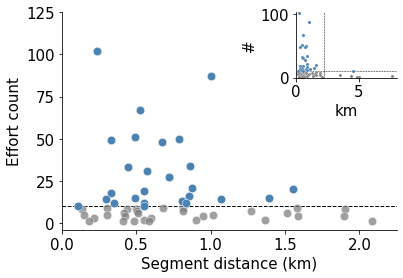

In [7]:
# Plotting
x, y = df_ec.segment_distance.values, df_ec.effort_count.values

fig, ax = plt.subplots(figsize=(6,4))
ax.plot([0, 2.25],[min_num_efforts, min_num_efforts], "k--", lw=1, zorder=0)
ax.scatter(x, y, s=70, alpha=0.75, color="gray", edgecolors="w", linewidths=.5)
ax.scatter(x[min_num_idx], y[min_num_idx], s=70, alpha=0.95, color="steelblue", edgecolors="w", linewidths=.5, zorder=5)
ax.set(xlabel="Segment distance (km)", ylabel="Effort count")
ax.set(xlim=(0, 2.25), xticks=list(np.arange(0, 2.5, 0.5)), yticks=list(np.arange(0, 125+25, 25)))

# Inset
cax = inset_axes(ax, width="30%", height="30%", loc="upper right", bbox_to_anchor=(-.0, -0.0, 1, 1),  # adjust position inside ax (x0, y0, width, height)
                 bbox_transform=ax.transAxes, borderpad=0)
cax.plot([0, 8],[min_num_efforts, min_num_efforts], "k--", lw=.5, zorder=0)
cax.plot([2.25, 2.25],[0, max_effort], "k--", lw=.5, zorder=0)
cax.scatter(x, y, s=10, color="gray", edgecolors="w", linewidths=.25)
cax.scatter(x[min_num_idx], y[min_num_idx], s=10, color="steelblue", edgecolors="w", linewidths=.25, zorder=5)
cax.set(xlabel="km", ylabel="#", xlim=(0,8), ylim=(0, max_effort));

fdict["fname"] = f"{results_save_path}/segment_effort_counts_minnumefforts_{min_num_efforts}_thresholding.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

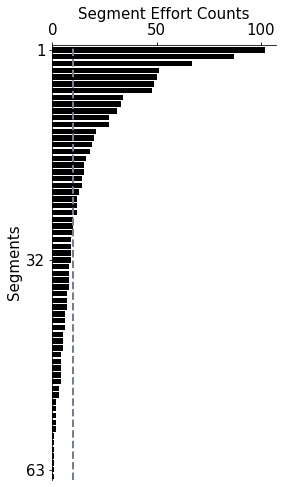

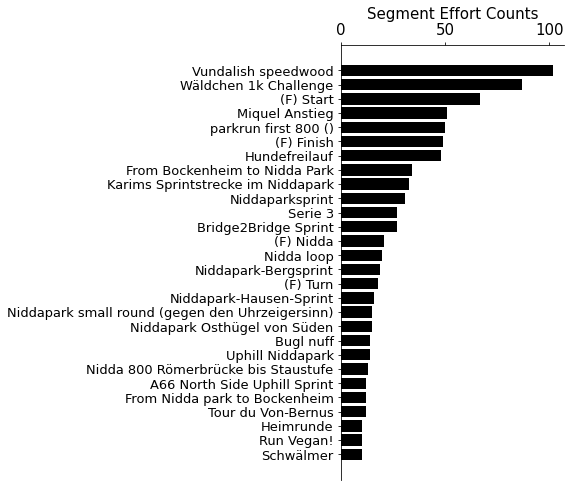

In [8]:
num_segs = df.segment_name.nunique()

# Plotting
fig, ax = plt.subplots(figsize=(4,8))
ax.barh(effort_count_df.index[::-1], effort_count_df.values[::-1], color="black")
ax.vlines(min_num_efforts, -.5, num_segs - .25, color="slategray", linestyle="--", lw=2)
plt.yticks(ticks=[num_segs-1, num_segs // 2, num_segs-(num_segs-1)], labels=[f"{num_segs-(num_segs-1)}", f"{num_segs // 2}", f"{num_segs-1}"]);
ax.set(ylim=(-.5, num_segs - .25))
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.spines['top'].set_visible(True); ax.spines['bottom'].set_visible(False)
plt.xlabel("Segment Effort Counts"); plt.ylabel("Segments")

fdict["fname"] = f"{results_save_path}/all-segment_counts.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None


fig, ax = plt.subplots(figsize=(4,8))
ax.barh(effort_count_df.index[n_segments-1::-1], effort_count_df.values[n_segments-1::-1], color="black")
plt.yticks(ticks=effort_count_df.index[n_segments-1::-1], labels=effort_count_df.index[n_segments-1::-1], rotation=0, fontsize=13);
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.spines['top'].set_visible(True); ax.spines['bottom'].set_visible(False)
plt.xlabel("Segment Effort Counts")

fdict["fname"] = f"{results_save_path}/segment_counts_names_minnumefforts_{min_num_efforts}.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# Individual Segment Analysis
NOTES:
- micquel anstieg has a lot of glitches (presumably as it goes under the bridge); many efforts would have to be excluded
- (F) Start, moderate progression, probably because also ran this while entering niddapark, maybe only secondary efforts here
- Wäldchen 1k Challenge, great progression but only data till end of october, is clean (judged by grade profile)
- Nidda loop: little improvment over time, but also good!
- (F) Finish (*), shohw nice progression! and is clean! but no grade (judged by grade profile)
- Hundefreilauf (**), nice progression and pace under 5min/km > is clean but also no grade (judged by grade profile)
- parkrun first 800 () (***) - nice, smooth progression, clean grade profile, generally clean and consistent (top10 & top20)
- Karims Sprintstrecke im Niddapark, not so good...
- Bridge2Bridge Sprint, little progression
- Serie 3, little progression (started this segment end of october)
- Niddaparksprint, same as above
- Niddapark-Bergsprint (**), slight progression, clean grade profile
- Niddapark small round (gegen den Uhrzeigersinn), cool massive progression but large gap inbetween
- 500m mit Steigung Training Schlierseelauf (*), no progression > started to run this mid-nov, already fast, clean grade profile
- Bugl nuff (*), little data but grade profile clean
- A66 North Side Uphill Sprint (*), little data but clean grade profile
- Uphill Niddapark (**), little data but good progression, clean grade profile
- Niddapark Osthügel von Süden (**), little data, clean grade profile
- (F) Nidda (*), relatively clean grade profile

# Interpolate grade and long / lat of segments

In [9]:
LOAD_DICT = True
num_segments_processed = 45
segments = list(effort_count_df.index[:num_segments_processed])

if LOAD_DICT:
    grade_dict = load_dict_from_json(f"{results_save_path}grade_dict_{len(segments)}.json")
else:
    grade_dict = dict()
    for nth_iter, name in enumerate(segments):
        igrade, ilat, ilong = list(), list(), list()
        df_seg_ = df.loc[df.segment_name == name, :].reset_index(drop=True)
        # only top 5 efforts
        df_seg_ = df_seg_.sort_values(by="moving_time", ascending=True)[:5]
        # interp grid
        ### CHANGE NUMPOINTS HERE   
        num_points = int(df_seg_["distance"].mean())  # num_points = int(df_seg_["distance"].max() // 5)
        distance_grid = np.linspace(0, df_seg_["distance"].max(), num=num_points)
        
        for nth, row in df_seg_.iterrows():
            id, start_idx, end_idx = row["activity_id"], row["start_index"], row["end_index"]
            stream = get_activity_stream_by_id(id, ACCESS_TOKEN)
            df_tmp = slice_stream_by_segment_indices(stream, [(start_idx, end_idx)])
            
            # grade interp
            igrade.append(np.interp(distance_grid, df_tmp["seg_distance"], df_tmp["grade_smooth"]))
            # lat long interp
            ilat.append(np.interp(distance_grid, df_tmp["seg_distance"], df_tmp["latitude"]))
            ilong.append(np.interp(distance_grid, df_tmp["seg_distance"], df_tmp["longitude"]))
            time.sleep(1)
        
        # how long: 40minutes for 40 segments, say these results for later use....
        grade_dict[name] = dict(distance=list(distance_grid),
                                grade_smooth=list(np.nanmean(np.array(igrade), axis=0)),
                                latitude=list(np.nanmean(np.array(ilat), axis=0)),
                                longitude=list(np.nanmean(np.array(ilong), axis=0)))

    save_dict_to_json(grade_dict, f"{results_save_path}grade_dict_{len(grade_dict.keys())}.json")

45


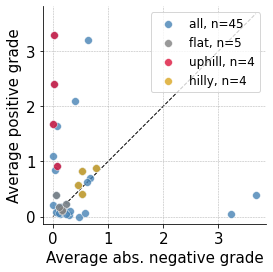

In [10]:
print(len(grade_dict.keys()))
neg_sum, pos_sum, neg_mean, pos_mean = list(), list(), list(), list()

for key, val in grade_dict.items():
    val["grade_smooth"] = np.array(val["grade_smooth"])
    # negative grades
    neg_sum.append(np.sum(val["grade_smooth"][val["grade_smooth"] < 0]) / len(val["grade_smooth"]))
    # positive grades
    pos_sum.append(np.sum(val["grade_smooth"][val["grade_smooth"] > 0]) / len(val["grade_smooth"]))

# replace nan with 0
neg_sum = np.array(neg_sum)
pos_sum = np.array(pos_sum)
neg_sum[np.isnan(neg_sum)] = 0
pos_sum[np.isnan(pos_sum)] = 0
limits = (np.nanmax(pos_sum), np.nanmax(np.abs(neg_sum)))

segment_categories = {
    "flat": {"segments": ["Wäldchen 1k Challenge", "Niddapark Northbound Sprint", 
                          "Karims Sprintstrecke im Niddapark", "(F) Start", "parkrun first 800 ()"],
             "color": "gray"},
    "uphill": {"segments": ["Bugl nuff", "Miquel Anstieg", "A66 North Side Uphill Sprint", "Niddapark Osthügel von Süden"], "color": "crimson"},
    "hilly": {"segments": ["Uphill Niddapark", "Niddapark-Bergsprint", "500m mit Steigung Training Schlierseelauf", "Heimrunde"], "color": "goldenrod"}
}

fig, ax = plt.subplots(figsize=(4,4))
ax.plot([0, max(limits)],[0, max(limits)], "k--", lw=1, zorder=1)
ax.scatter(np.abs(neg_sum), pos_sum, s=60, alpha=0.8, color="steelblue", edgecolors="w", zorder=3, linewidths=.5, label=f"all, n={num_segments_processed}")

for category, data in segment_categories.items():
    x_vals = [np.abs(neg_sum[nth]) for nth, key in enumerate(grade_dict.keys()) if key in data["segments"]]
    y_vals = [pos_sum[nth] for nth, key in enumerate(grade_dict.keys()) if key in data["segments"]]
    
    ax.scatter(x_vals, y_vals, s=60, alpha=0.8, color=data["color"], edgecolors="w", zorder=3, linewidths=.5, label=f"{category}, n={len(data['segments'])}")

ax.set(ylabel="Average positive grade", xlabel="Average abs. negative grade")
ax.set(xlim=(0, max(limits)), ylim=(0, max(limits)), xticks=np.arange(0, np.floor(max(limits))+1, 1), yticks=np.arange(0, np.floor(max(limits))+1, 1))
ax.grid(True, linestyle="--", linewidth=0.5, zorder=0)
plt.legend(fontsize=12, loc="upper right")
plt.axis("equal");

fdict["fname"] = f"{results_save_path}/segments_summed_grade_nsegments{len(grade_dict.keys())}.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

In [11]:
[f"{k} : {np.round(pos,2)}, {np.round(neg,2)}" for k, pos, neg in zip(list(grade_dict.keys()), pos_sum, neg_sum)]
[f"{k} : {np.round(pos,2)}, {np.round(neg,2)}" for k, pos, neg in zip(list(grade_dict.keys()), pos_sum, neg_sum) if pos > .25 and neg < -.25]

['Niddapark-Bergsprint : 0.82, -0.52',
 'Uphill Niddapark : 0.41, -0.52',
 'Tour du Von-Bernus : 0.7, -0.66',
 'Heimrunde : 0.57, -0.44',
 'Bridge Sprint ala Kruger : 0.39, -3.68',
 '500m mit Steigung Training Schlierseelauf : 0.88, -0.78',
 'The 3 Hills - Nidda -> Grüni : 2.1, -0.4',
 '400m Bahn Niddatalpark : 0.63, -0.62',
 'Bridge Sprint : 3.2, -0.64']

# All segment types

pace correlation coef: -0.54 and p-value:  5.3e-20; n=245
heart rate correlation coef: 0.25 and p-value:  7.0e-05; n=245


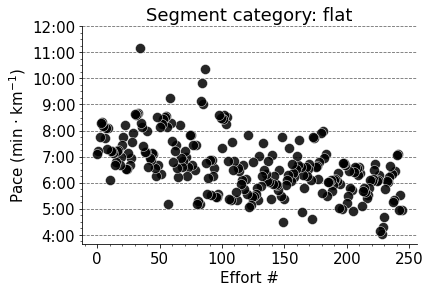

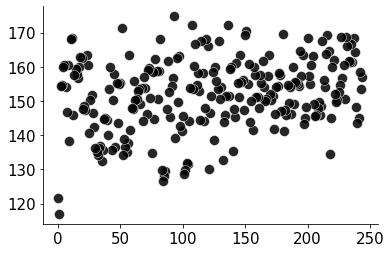

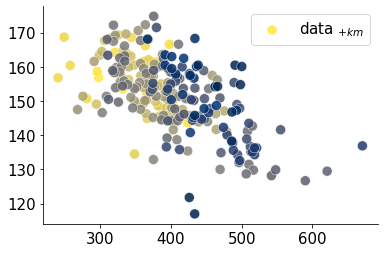

In [12]:
segcat = "flat"
df_segcat = df.loc[df.segment_name.isin(segment_categories[segcat]["segments"]), :].reset_index(drop=True)

# sorted efforts
df_segcat_ = df_segcat.sort_values(by="start_date_local", ascending=False).reset_index(drop=True)
df_segcat_["nth_effort"] = list(range(len(df_segcat)))[::-1]
ypace_ = df_segcat_["pace_sec"].values

# Pace and HR correlation over time
corr_coef, p_value = pearsonr(df_segcat_["nth_effort"].values, df_segcat_["pace_sec"].values);
print(f"pace correlation coef: {np.round(corr_coef, 2)} and p-value: {p_value: .1e}; n={len(df_segcat)}")

corr_coef, p_value = pearsonr(df_segcat_["nth_effort"].values, df_segcat_["average_heartrate"].values);
print(f"heart rate correlation coef: {np.round(corr_coef, 2)} and p-value: {p_value: .1e}; n={len(df_segcat)}")

# Efforts per date
xdate = df_segcat["start_date_local"].values
ypace = df_segcat["pace_sec"].values

# Pace labels
min_pace, max_pace = ypace.min(), ypace.max()
lower = int(np.floor(min_pace / 60))
upper = int(np.ceil(max_pace / 60))
pace_labels = dict(min_pace=f"{lower}:00", max_pace=f"{upper}:00", step="1:00", axis="y")

# Plotting
fig, ax = plt.subplots()
ax.scatter(df_segcat_["nth_effort"].values, ypace_, color="k", alpha=0.85, edgecolors='w', linewidth=0.5, s=100, zorder=4)
apply_pace_labels(ax, **pace_labels)
ax.grid(axis='y', linestyle='--', color='dimgray')
ax.minorticks_on()
ax.set(xlabel="Effort #", ylabel="Pace (min · km$^{-1}$)", title=f"Segment category: {segcat}");


# Plotting
fig, ax = plt.subplots()
ax.scatter(df_segcat_["nth_effort"].values, df_segcat_["average_heartrate"].values, color="k", alpha=0.85, edgecolors='w', linewidth=0.5, s=100, zorder=4);

fig, ax = plt.subplots()
ax.scatter(df_segcat_["pace_sec"].values, df_segcat_["average_heartrate"].values, c=df_segcat_["nth_effort"].values, cmap="cividis", alpha=0.85, edgecolors='w', linewidth=0.5, s=100, zorder=4, label="data $_{+km}$");
plt.legend()

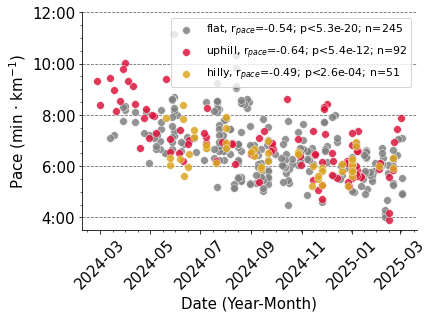

In [13]:
pace_labels = dict(min_pace=f"{4}:00", max_pace=f"{12}:00", step="2:00", axis="y")
fig, ax = plt.subplots(figsize=(6,4))

for segcat in segment_categories.keys():
    df_segcat = df.loc[df.segment_name.isin(segment_categories[segcat]["segments"]), :].reset_index(drop=True)

    # sorted efforts
    df_segcat_ = df_segcat.sort_values(by="start_date_local", ascending=False).reset_index(drop=True)
    df_segcat_["nth_effort"] = list(range(len(df_segcat)))[::-1]
    ypace_ = df_segcat_["pace_sec"].values

    # Pace and HR correlation over time
    pace_corr_coef, pace_p_value = pearsonr(df_segcat_["nth_effort"].values, df_segcat_["pace_sec"].values);
    #hr_corr_coef, hr_p_value = pearsonr(df_segcat_["nth_effort"].values, df_segcat_["average_heartrate"].values);
    label = f"{segcat}, r$_{{pace}}$={pace_corr_coef:.2f}; p<{pace_p_value:.1e}; n={len(df_segcat_)}"    
    
    # Efforts per date
    xdate = df_segcat["start_date_local"].values
    ypace = df_segcat["pace_sec"].values

    ax.scatter(xdate, ypace, color=segment_categories[segcat]["color"], alpha=0.85, edgecolors='w', linewidth=0.5, s=60, zorder=4, label=label)

apply_pace_labels(ax, **pace_labels)
ax.grid(axis='y', linestyle='--', color='dimgray')
ax.minorticks_on()
ax.set(xlabel="Date (Year-Month)", ylabel="Pace (min · km$^{-1}$)");
plt.xticks(rotation=45);
plt.legend(fontsize=11, loc="upper right");

fdict["fname"] = f"{results_save_path}/pooled_pace_vs_effort_segment_for_flat_hilly_uphill.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# Single segment
- re-check as pd.datetime and pd.timedelat are now edefined at the start above

In [14]:
# Individual segment
name = "Wäldchen 1k Challenge"#"Heimrunde"#"Miquel Anstieg"#"Karims Sprintstrecke im Niddapark"#"parkrun first 800 ()"#"Niddapark Northbound Sprint"#"(F) Start"#"500m mit Steigung Training Schlierseelauf"#"A66 North Side Uphill Sprint"#"#"Miquel Anstieg"# #"Uphill Niddapark"# "#"Nidda loop" # 

df_seg = df.loc[df.segment_name == name, :].reset_index(drop=True)
x = df_seg.loc[:, "start_date_local"]
x2 = pd.to_datetime(x)
x2_rev = x2[::-1]

y = df_seg.loc[:, "pace_min_per_km"]
y2 = pd.to_timedelta(y * 60, unit='s')  # only timedelta seconds can be plotted
ysec = y2.dt.total_seconds()

# effort #
xefforts = list(range(len(x)))  
xefforts_rev = xefforts[::-1]

corr_coef, p_value = pearsonr(xefforts, y)
print(f"correlation coef: {np.round(corr_coef, 2)} and p_val < {p_value: .1e}; n={len(x)}")

# SORT Top efforts
top_n = 10
top_n_efforts = ysec.sort_values().index.values[:top_n]
top_n_ysec = ysec[top_n_efforts]
top_n_xefforts = [xefforts_rev[e] for e in top_n_efforts[::-1]]
top_n_x2 = [x2_rev[e] for e in top_n_efforts[::-1]]

# loop over ids and extract time-dependent information 
unique_actids = df_seg.loc[top_n_efforts, "activity_id"].unique().astype(str)
segment_id = df_seg.loc[0, "segment_id"]
print(f"top {top_n} segment efforts in {len(unique_actids)} unique activitites\nExample activity and segment id:{unique_actids[0]} | {segment_id}")

df_seg.iloc[top_n_efforts, :].head(top_n)

correlation coef: 0.54 and p_val <  5.8e-08; n=87
top 10 segment efforts in 6 unique activitites
Example activity and segment id:13767693967 | 20942819


,segment_name,activity_id,name,start_date_local,distance,moving_time,start_index,end_index,average_cadence,average_heartrate,velocity_kmh,pace_min_per_km,segment_id,pace_sec
2,Wäldchen 1k Challenge,13767693967,Wäldchen 1k Challenge,2025-03-02 12:35:13+00:00,1003.7,297,457,755,87.5,158.6,12.166061,4.931753,20942819,295.905151
0,Wäldchen 1k Challenge,13767693967,Wäldchen 1k Challenge,2025-03-02 12:53:42+00:00,1003.7,299,1226,1531,87.7,156.9,12.084682,4.964963,20942819,297.897778
12,Wäldchen 1k Challenge,12406945202,Wäldchen 1k Challenge,2024-09-14 13:12:50+00:00,1003.7,304,7,314,85.0,146.6,11.885921,5.047989,20942819,302.879346
14,Wäldchen 1k Challenge,12406945202,Wäldchen 1k Challenge,2024-09-14 13:22:25+00:00,1003.7,310,336,652,59.5,151.4,11.655871,5.147620,20942819,308.857228
40,Wäldchen 1k Challenge,12108844456,Wäldchen 1k Challenge,2024-08-10 10:09:13+00:00,1003.7,311,1218,1530,85.2,168.0,11.618392,5.164226,20942819,309.853542
58,Wäldchen 1k Challenge,11941667338,Wäldchen 1k Challenge,2024-07-21 10:27:38+00:00,1003.7,312,2618,2929,87.9,163.4,11.581154,5.180831,20942819,310.849856
38,Wäldchen 1k Challenge,12108844456,Wäldchen 1k Challenge,2024-08-10 09:47:31+00:00,1003.7,313,418,730,84.1,150.5,11.544153,5.197436,20942819,311.846169
39,Wäldchen 1k Challenge,12108844456,Wäldchen 1k Challenge,2024-08-10 09:58:12+00:00,1003.7,319,820,1138,85.3,158.9,11.327022,5.297068,20942819,317.824051
17,Wäldchen 1k Challenge,12279776892,Wäldchen 1k Challenge,2024-08-30 11:23:06+00:00,1003.7,320,784,1106,85.5,172.2,11.291625,5.313673,20942819,318.820365
9,Wäldchen 1k Challenge,12458069077,Wäldchen 1k Challenge,2024-09-20 14:07:54+00:00,1003.7,320,1471,1792,86.0,167.5,11.291625,5.313673,20942819,318.820365


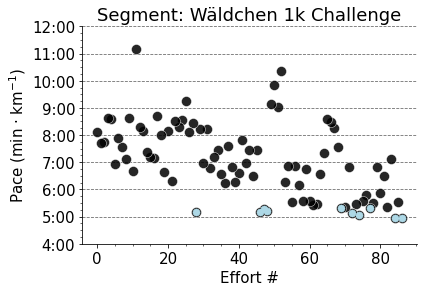

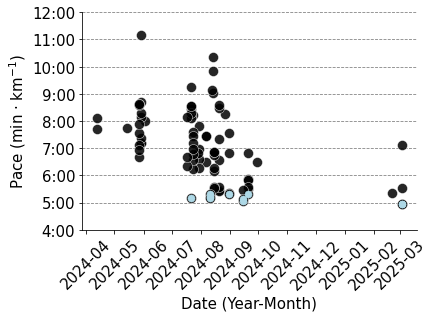

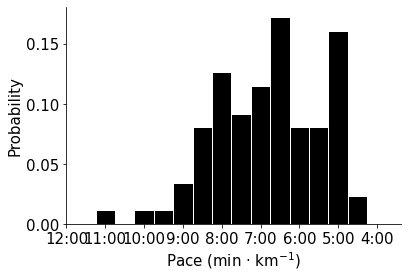

In [15]:
min_pace, max_pace = ysec.min(), ysec.max()
lower = int(np.floor(min_pace / 60))
upper = int(np.ceil(max_pace / 60))
pace_labels = dict(min_pace=f"{lower}:00", max_pace=f"{upper}:00", step="1:00", axis="y")

# SCATTER
fig, ax = plt.subplots()
ax.scatter(xefforts[::-1], ysec, color="k", alpha=0.85, edgecolors='w', linewidth=0.5, s=100, zorder=4)
ax.scatter(top_n_xefforts[::-1], top_n_ysec, color="lightblue", alpha=1, edgecolors='lightblue', linewidth=.5, s=50, zorder=5)
apply_pace_labels(ax, **pace_labels)
ax.grid(axis='y', linestyle='--', color='dimgray')

ax.minorticks_on()
ax.set(xlabel="Effort #", ylabel="Pace (min · km$^{-1}$)", title="Segment: " + name);

fdict["fname"] = f"{results_save_path}/pace_vs_effort_segment_{name}_topn_{top_n}.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# SCATTER Date
fig, ax = plt.subplots()
ax.scatter(x2, ysec, color="k", alpha=0.85, edgecolors='w', linewidth=0.5, s=100, zorder=4)
ax.scatter(top_n_x2[::-1], top_n_ysec, color="lightblue", alpha=1, edgecolors='lightblue', linewidth=.5, s=50, zorder=5)  # gold
apply_pace_labels(ax, **pace_labels)
ax.set(xlabel="Date (Year-Month)", ylabel="Pace (min · km$^{-1}$)");
ax.grid(axis='y', linestyle='--', color='gray')
plt.xticks(rotation=45);

fdict["fname"] = f"{results_save_path}/pace_vs_date_segment_{name}_topn_{top_n}.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# BAR
pace_labels["axis"] = "x"
bin_edges = pd.to_timedelta([f"00:{m:02d}:{s:02d}" for m in range(4, 9) for s in [0, 30]]).total_seconds()
step_size = 30
bin_edges = pd.to_timedelta(np.arange(lower*60, upper*60, step_size), unit='s').total_seconds()

counts, bins = np.histogram(ysec, bins=bin_edges)

fig, ax = plt.subplots()
ax.bar(bin_edges[:-1], counts / sum(counts), width=step_size, edgecolor='white', color="black")
apply_pace_labels(ax, **pace_labels)
ax.invert_xaxis()
plt.xlabel("Pace (min · km$^{-1}$)"); plt.ylabel("Probability")

fdict["fname"] = f"{results_save_path}/pace_distribution_segment_{name}_topn_{top_n}.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# Segment Stream (t-dep) for unique top_n activties
- normalize time / distance per start/end_index
- make sure that only the wanted top_n efforts go in!!!

In [16]:
df_seg_top = df_seg.loc[top_n_efforts].reset_index(drop=True)
df_seg_top

,segment_name,activity_id,name,start_date_local,distance,moving_time,start_index,end_index,average_cadence,average_heartrate,velocity_kmh,pace_min_per_km,segment_id,pace_sec
0,Wäldchen 1k Challenge,13767693967,Wäldchen 1k Challenge,2025-03-02 12:35:13+00:00,1003.7,297,457,755,87.5,158.6,12.166061,4.931753,20942819,295.905151
1,Wäldchen 1k Challenge,13767693967,Wäldchen 1k Challenge,2025-03-02 12:53:42+00:00,1003.7,299,1226,1531,87.7,156.9,12.084682,4.964963,20942819,297.897778
2,Wäldchen 1k Challenge,12406945202,Wäldchen 1k Challenge,2024-09-14 13:12:50+00:00,1003.7,304,7,314,85.0,146.6,11.885921,5.047989,20942819,302.879346
3,Wäldchen 1k Challenge,12406945202,Wäldchen 1k Challenge,2024-09-14 13:22:25+00:00,1003.7,310,336,652,59.5,151.4,11.655871,5.147620,20942819,308.857228
4,Wäldchen 1k Challenge,12108844456,Wäldchen 1k Challenge,2024-08-10 10:09:13+00:00,1003.7,311,1218,1530,85.2,168.0,11.618392,5.164226,20942819,309.853542
5,Wäldchen 1k Challenge,11941667338,Wäldchen 1k Challenge,2024-07-21 10:27:38+00:00,1003.7,312,2618,2929,87.9,163.4,11.581154,5.180831,20942819,310.849856
6,Wäldchen 1k Challenge,12108844456,Wäldchen 1k Challenge,2024-08-10 09:47:31+00:00,1003.7,313,418,730,84.1,150.5,11.544153,5.197436,20942819,311.846169
7,Wäldchen 1k Challenge,12108844456,Wäldchen 1k Challenge,2024-08-10 09:58:12+00:00,1003.7,319,820,1138,85.3,158.9,11.327022,5.297068,20942819,317.824051
8,Wäldchen 1k Challenge,12279776892,Wäldchen 1k Challenge,2024-08-30 11:23:06+00:00,1003.7,320,784,1106,85.5,172.2,11.291625,5.313673,20942819,318.820365
9,Wäldchen 1k Challenge,12458069077,Wäldchen 1k Challenge,2024-09-20 14:07:54+00:00,1003.7,320,1471,1792,86.0,167.5,11.291625,5.313673,20942819,318.820365


In [17]:
act_list = list()

for nth, row in df_seg_top.iterrows():
    id, start_idx, end_idx, sdlocal = row["activity_id"], row["start_index"], row["end_index"], row["start_date_local"]
    stream = get_activity_stream_by_id(id, ACCESS_TOKEN)
    df_tmp = slice_stream_by_segment_indices(stream, [(start_idx, end_idx)])
    df_tmp["effort"] = int(nth)

    # NORMALIZE EVERY EFFORTS TIME AND DISTANCE BY START_TIME_DISTANCE
    df_tmp["date"] = sdlocal
    df_tmp["date"] = pd.to_datetime(df_tmp["date"])
    df_tmp['adjusted_date'] = df_tmp["date"] + pd.to_timedelta(df_tmp['time'], unit='m')
    act_list.append(df_tmp)

df_ = pd.concat(act_list, ignore_index=True)
df_

,velocity_smooth,grade_smooth,cadence,distance,altitude,heartrate,time,seg_time,seg_distance,latitude,longitude,effort,date,adjusted_date
0,7.3440,3.6,80,1090.0,101.3,122,8.750000,0.000000,0.0,50.142210,8.635548,0,2025-03-02 12:35:13+00:00,2025-03-02 12:43:58+00:00
1,9.0000,3.6,81,1094.4,101.5,121,8.766667,0.016667,4.4,50.142242,8.635507,0,2025-03-02 12:35:13+00:00,2025-03-02 12:43:59.000000002+00:00
2,7.4880,3.5,81,1094.4,101.5,121,8.783333,0.033333,4.4,50.142242,8.635507,0,2025-03-02 12:35:13+00:00,2025-03-02 12:43:59.999999998+00:00
3,8.0640,3.1,81,1096.9,101.6,121,8.800000,0.050000,6.9,50.142263,8.635496,0,2025-03-02 12:35:13+00:00,2025-03-02 12:44:01+00:00
4,8.0640,3.2,82,1099.1,101.6,121,8.816667,0.066667,9.1,50.142283,8.635490,0,2025-03-02 12:35:13+00:00,2025-03-02 12:44:02.000000002+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3117,11.7288,0.0,87,5072.3,100.8,183,32.133333,5.266667,971.1,50.142086,8.635965,9,2024-09-20 14:07:54+00:00,2024-09-20 14:40:01.999999998+00:00
3118,10.5480,0.0,87,5074.5,100.8,183,32.150000,5.283333,973.3,50.142081,8.635936,9,2024-09-20 14:07:54+00:00,2024-09-20 14:40:03+00:00
3119,10.0368,1.0,87,5077.2,100.8,184,32.166667,5.300000,976.0,50.142071,8.635898,9,2024-09-20 14:07:54+00:00,2024-09-20 14:40:04.000000002+00:00
3120,9.8280,1.0,87,5079.9,100.8,183,32.183333,5.316667,978.7,50.142084,8.635866,9,2024-09-20 14:07:54+00:00,2024-09-20 14:40:04.999999998+00:00


- Segment stream pace

In [18]:
# RELOOK HERE : STUFF DEFINED ABOVE
# y = df_seg.loc[:, "pace_min_per_km"]
# y2 = pd.to_timedelta(y * 60, unit='s')  # only timedelta seconds can be plotted
# ysec = y2.dt.total_seconds()

# convert all to pace_sec
max_velocity = 30  # km/h
max_pace = 13  # min/km

# Filter out unrealistic velocities
cond = (df_["velocity_smooth"] < 2) | (df_["velocity_smooth"] > max_velocity)
df_["velocity_smooth"] = np.where(cond, np.nan, df_["velocity_smooth"])

df_["pace"] = 60 / df_["velocity_smooth"]
df_["pace"] = df_["pace"].replace([np.inf, -np.inf], np.nan)
df_["pace"] = df_["pace"].clip(lower=0, upper=max_pace)

# time delta
df_["pace_timedelta"] = pd.to_timedelta(df_["pace"], unit="m")
df_["pace_sec"] = df_["pace_timedelta"].dt.total_seconds()

# Pace limits
lower = int(np.floor(df_["pace_sec"].min() / 60))
upper = int(np.ceil(df_["pace_sec"].max() / 60))
pace_labels = dict(min_pace=f"{lower}:00", max_pace=f"{upper}:00", step="1:00", axis="y")
print(f'SORTED EFFORTS: {df_.groupby("effort")["pace_sec"].mean()[:5]}')
df_.head(5)

SORTED EFFORTS: effort
0    321.736583
1    332.799256
2    321.120741
3    339.855194
4    328.713658
Name: pace_sec, dtype: float64


,velocity_smooth,grade_smooth,cadence,distance,altitude,heartrate,time,seg_time,seg_distance,latitude,longitude,effort,date,adjusted_date,pace,pace_timedelta,pace_sec
0,7.344,3.6,80,1090.0,101.3,122,8.750000,0.000000,0.0,50.142210,8.635548,0,2025-03-02 12:35:13+00:00,2025-03-02 12:43:58+00:00,8.169935,0 days 00:08:10.196078430,490.196078
1,9.000,3.6,81,1094.4,101.5,121,8.766667,0.016667,4.4,50.142242,8.635507,0,2025-03-02 12:35:13+00:00,2025-03-02 12:43:59.000000002+00:00,6.666667,0 days 00:06:40.000000002,400.000000
2,7.488,3.5,81,1094.4,101.5,121,8.783333,0.033333,4.4,50.142242,8.635507,0,2025-03-02 12:35:13+00:00,2025-03-02 12:43:59.999999998+00:00,8.012821,0 days 00:08:00.769230768,480.769231
3,8.064,3.1,81,1096.9,101.6,121,8.800000,0.050000,6.9,50.142263,8.635496,0,2025-03-02 12:35:13+00:00,2025-03-02 12:44:01+00:00,7.440476,0 days 00:07:26.428571430,446.428571
4,8.064,3.2,82,1099.1,101.6,121,8.816667,0.066667,9.1,50.142283,8.635490,0,2025-03-02 12:35:13+00:00,2025-03-02 12:44:02.000000002+00:00,7.440476,0 days 00:07:26.428571430,446.428571


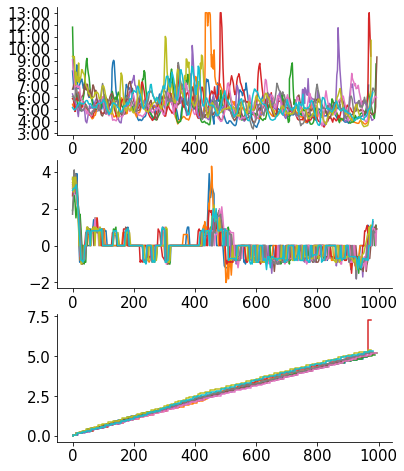

In [19]:
fig, ax = plt.subplots(3,1, figsize=(6,8))

for effort, group in df_.groupby("effort"):
    ax[0].plot(group["seg_distance"], group["pace_sec"])
apply_pace_labels(ax[0], **pace_labels)

for effort, group in df_.groupby("effort"):
    ax[1].plot(group["seg_distance"], group["grade_smooth"])

for effort, group in df_.groupby("effort"):
    ax[2].step(group["seg_distance"][::5], group["seg_time"][::5])
    #print(group["seg_time"][::5].diff().max())

# have to clean those up!!!

## Single segment multi-effort interpolation
- to be able to construct an average

In [20]:
df_

,velocity_smooth,grade_smooth,cadence,distance,altitude,heartrate,time,seg_time,seg_distance,latitude,longitude,effort,date,adjusted_date,pace,pace_timedelta,pace_sec
0,7.3440,3.6,80,1090.0,101.3,122,8.750000,0.000000,0.0,50.142210,8.635548,0,2025-03-02 12:35:13+00:00,2025-03-02 12:43:58+00:00,8.169935,0 days 00:08:10.196078430,490.196078
1,9.0000,3.6,81,1094.4,101.5,121,8.766667,0.016667,4.4,50.142242,8.635507,0,2025-03-02 12:35:13+00:00,2025-03-02 12:43:59.000000002+00:00,6.666667,0 days 00:06:40.000000002,400.000000
2,7.4880,3.5,81,1094.4,101.5,121,8.783333,0.033333,4.4,50.142242,8.635507,0,2025-03-02 12:35:13+00:00,2025-03-02 12:43:59.999999998+00:00,8.012821,0 days 00:08:00.769230768,480.769231
3,8.0640,3.1,81,1096.9,101.6,121,8.800000,0.050000,6.9,50.142263,8.635496,0,2025-03-02 12:35:13+00:00,2025-03-02 12:44:01+00:00,7.440476,0 days 00:07:26.428571430,446.428571
4,8.0640,3.2,82,1099.1,101.6,121,8.816667,0.066667,9.1,50.142283,8.635490,0,2025-03-02 12:35:13+00:00,2025-03-02 12:44:02.000000002+00:00,7.440476,0 days 00:07:26.428571430,446.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3117,11.7288,0.0,87,5072.3,100.8,183,32.133333,5.266667,971.1,50.142086,8.635965,9,2024-09-20 14:07:54+00:00,2024-09-20 14:40:01.999999998+00:00,5.115613,0 days 00:05:06.936771024,306.936771
3118,10.5480,0.0,87,5074.5,100.8,183,32.150000,5.283333,973.3,50.142081,8.635936,9,2024-09-20 14:07:54+00:00,2024-09-20 14:40:03+00:00,5.688282,0 days 00:05:41.296928328,341.296928
3119,10.0368,1.0,87,5077.2,100.8,184,32.166667,5.300000,976.0,50.142071,8.635898,9,2024-09-20 14:07:54+00:00,2024-09-20 14:40:04.000000002+00:00,5.978001,0 days 00:05:58.680057390,358.680057
3120,9.8280,1.0,87,5079.9,100.8,183,32.183333,5.316667,978.7,50.142084,8.635866,9,2024-09-20 14:07:54+00:00,2024-09-20 14:40:04.999999998+00:00,6.105006,0 days 00:06:06.300366300,366.300366


In [21]:
# Interpolate values so that efforts can be averaged
igrade, ipace, ilat, ilong = list(), list(), list(), list()  # interpolated values
# USE A DICT

num_points = int(df_.groupby("effort")["seg_distance"].max().mean())  # df_["seg_distance"].max() // 5
distance_grid = np.linspace(0, df_["seg_distance"].max(), num=num_points)  # df_["seg_distance"].min()

for effort, group in df_.groupby("effort"):
    igrade.append(np.interp(distance_grid, group["seg_distance"], group["grade_smooth"]))
    ipace.append(np.interp(distance_grid, group["seg_distance"], group["pace_sec"]))
    ilat.append(np.interp(distance_grid, group["seg_distance"], group["latitude"]))
    ilong.append(np.interp(distance_grid, group["seg_distance"], group["longitude"]))

# Lat and Long average
#top_n = 10 # 10 above
mean_ilat = np.nanmean(np.array(ilat)[:top_n,:], axis=0)
mean_ilong = np.nanmean(np.array(ilong)[:top_n,:], axis=0)

# Pace average
pace_matrix = np.array(ipace)
pace_matrix_topn = np.array(ipace)[:top_n,:]
mean_pace = np.nanmean(pace_matrix_topn, axis=0)
std_pace = np.nanstd(pace_matrix_topn, axis=0)

min_pace, max_pace = mean_pace.min(), mean_pace.max()
lower = int(np.floor(min_pace / 60)) - 1
upper = int(np.ceil(max_pace / 60)) + 1
pace_labels = dict(min_pace=f"{lower}:00", max_pace=f"{upper}:00", step="1:00", axis="y")

# Grade average
mean_grade = np.nanmean(np.array(igrade), axis=0)
grade_max = max(np.max(mean_grade), np.abs(np.min(mean_grade)))

# Fastest segment effort

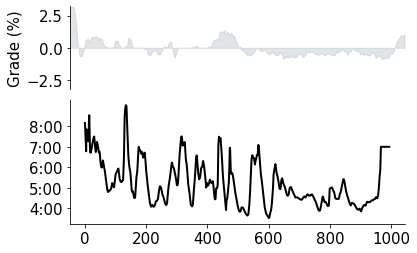

In [22]:
pace_labels = dict(min_pace=f"{4}:00", max_pace=f"{8}:00", step="1:00", axis="y")
df_best = pace_matrix_topn[0,:]
x = distance_grid

#mean_pace_, std_pace_ = np.nanmean(df_best["pace_sec"]), np.nanstd(df_best["pace_sec"])
#best_effort_pace = df_best["pace_sec"].rolling(window=5).mean().values.flatten()

# Plotting
fig, ax = plt.subplots(2,1, figsize=(6,4), height_ratios=[1,1.5], gridspec_kw={"hspace": .1})
# grade
ax[0].fill_between(distance_grid, mean_grade, color="slategray", alpha=0.2)
ax[0].set(ylim=(-grade_max, grade_max), xlim=(0, x.max()), ylabel="Grade (%)", xticks=[])
ax[0].spines["bottom"].set_visible(False)

# pace
ax[1].plot(x, df_best, color="k", lw=2, zorder=5, label="best pace")
apply_pace_labels(ax[1], **pace_labels)

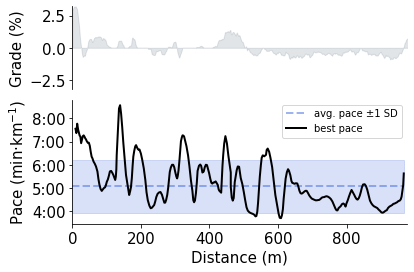

In [23]:
pace_labels = dict(min_pace=f"{4}:00", max_pace=f"{8}:00", step="1:00", axis="y")
df_best = df_[df_["effort"]==0].reset_index(drop=True)
x = df_best["seg_distance"]

mean_pace_, std_pace_ = np.nanmedian(df_best["pace_sec"]), np.nanstd(df_best["pace_sec"])
best_effort_pace = df_best["pace_sec"].rolling(window=5).mean().values.flatten()

# Plotting
fig, ax = plt.subplots(2,1, figsize=(6,4), height_ratios=[1,1.5], gridspec_kw={"hspace": .1})
# grade
ax[0].fill_between(distance_grid, mean_grade, color="slategray", alpha=0.2)
ax[0].set(ylim=(-grade_max, grade_max), xlim=(0, x.max()+10), ylabel="Grade (%)", xticks=[])
ax[0].spines["bottom"].set_visible(False)

# pace
ax[1].fill_between(x, mean_pace_ - std_pace_, mean_pace_ + std_pace_, color="royalblue", alpha=0.2)
ax[1].hlines(mean_pace_, 0, x.max(), color="royalblue", alpha=.5, lw=2, linestyle="--", label="avg. pace ±1 SD")
ax[1].plot(df_best["seg_distance"], best_effort_pace, color="k", lw=2, zorder=5, label="best pace")
ax[1].set(xlim=(0, x.max()+10), ylabel="Pace (min·km$^{-1}$)", xlabel="Distance (m)")
apply_pace_labels(ax[1], **pace_labels)
plt.legend(fontsize=10)

fdict["fname"] = f"{results_save_path}/best_pace_grade_segment_{name}_wo_interpolation.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# Interpolated

982, min: 3.6463695587333467, max: 8.10237933732895


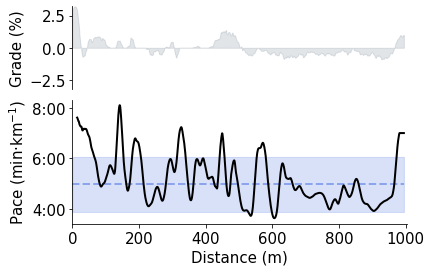

In [24]:
pace_labels = dict(min_pace=f"{4}:00", max_pace=f"{8}:00", step="2:00", axis="y")

# Plotting
plot_df = pd.DataFrame({"distance": distance_grid, "mean_pace": mean_pace, "std_pace": std_pace})
x = distance_grid
best_no = 0
mean_pace_, std_pace_ = np.nanmedian(pace_matrix_topn[best_no, :]), np.nanstd(pace_matrix_topn[best_no, :])
best_effort_pace = pd.DataFrame({"best_effort" : pace_matrix_topn[best_no, :]}).rolling(window=15).mean().values.flatten()
print(f"{len(best_effort_pace)}, min: {np.nanmin(best_effort_pace)/60}, max: {np.nanmax(best_effort_pace)/60}")

fig, ax = plt.subplots(2,1, figsize=(6,4), height_ratios=[1,1.5], gridspec_kw={"hspace": .1})
# grade
ax[0].fill_between(x, mean_grade, color="slategray", alpha=0.2)
ax[0].set(ylim=(-grade_max, grade_max), xlim=(0, x.max()+10), ylabel="Grade (%)", xticks=[])
ax[0].spines["bottom"].set_visible(False)

# pace
ax[1].fill_between(x, mean_pace_ - std_pace_, mean_pace_ + std_pace_, color="royalblue", alpha=0.2, label="mean pace ±1 SD")
ax[1].hlines(mean_pace_, 0, x.max(), color="royalblue", alpha=.5, lw=2, linestyle="--", label="mean pace")
ax[1].plot(x, best_effort_pace, color="k", lw=2, zorder=5)#, label="Fastest")
apply_pace_labels(ax[1], **pace_labels)
ax[1].set(xlim=(0, x.max()+10), ylabel="Pace (min·km$^{-1}$)", xlabel="Distance (m)")

fdict["fname"] = f"{results_save_path}/best_pace_interpolated_grade_segment_{name}_topn_{1}.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


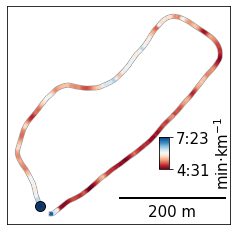

In [25]:
# w. Geopandas
vminmax = (min_pace, max_pace)
x, y = mean_ilong, mean_ilat
colors, sm = create_scalarmappable("RdBu", list(mean_pace), vminmax=vminmax)
ax_params = dict(yticks=[], xticks=[])

# Convert to GeoDataFrame
df_spatial = pd.DataFrame({"longitude": mean_ilong, "latitude": mean_ilat})
df_spatial["geometry"] = df_spatial.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
gdf = gpd.GeoDataFrame(df_spatial, geometry='geometry', crs="EPSG:4326")
gdf = gdf.to_crs(epsg=25832)
x, y = gdf.geometry.x.to_numpy(), gdf.geometry.y.to_numpy()

# Plotting 
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x[0], y[0], s=100, color=colors[0], alpha=.95, edgecolors="k", linewidths=1, zorder=5)
ax.plot(x, y, "-", color="gray", lw=5, alpha=.75)
plot_colorline(x, y, colors=colors, ax=ax, lw=3, alpha=.8)

bar_loc = "lower right"
# Colorbar
cax = inset_axes(ax, width="5%", height="20%", loc=bar_loc, bbox_to_anchor=(-0.175, 0.25, .9, .75) if bar_loc == "lower right" else (0.175, 0.25, .9, .75),  # adjust position inside ax (x0, y0, width, height)
                 bbox_transform=ax.transAxes, borderpad=0)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical', label='min·km$^{-1}$')
cbar.ax.set_yticks([max_pace, min_pace]);  #np.median(mean_pace),
cbar.ax.set_yticklabels([f"{format_pace(max_pace)}", f"{format_pace(min_pace)}"]); # f"{format_pace(np.median(mean_pace))}",

# Scalebar
scalebar = ScaleBar(1, units="m", location=bar_loc, scale_loc="bottom", length_fraction=0.5, box_alpha=.25)
ax.add_artist(scalebar)

ax.spines["top"].set_visible(True); ax.spines["right"].set_visible(True)
ax.set(**ax_params);

fdict["fname"] = f"{results_save_path}/mean_pace_color-coded_segment_{name}_topn_{top_n}_geopandas.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

## GEOPANDAS

{'min_pace': '3:31', 'max_pace': '8:23', 'step': '1:00', 'axis': 'y'}


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_2805/3456052700.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[0], y[0], s=100, c=colors[0], alpha=1, edgecolors="k", linewidths=1, zorder=5)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1

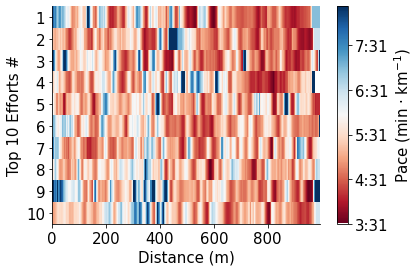

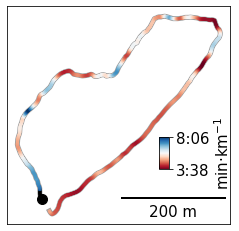

In [26]:
cmap_str = "RdBu"#"berlin"#"gist_ncar_r"#"vanimo"#"managua"#  # RdBu
vminmax_ = vminmax # (np.nanmin(pace_matrix_topn[0,:]), np.nanmax(pace_matrix_topn)) # 
plus_minus = 60 # seconds
pace_labels = dict(min_pace=f"{format_pace(vminmax_[0] - plus_minus)}", max_pace=f"{format_pace(vminmax_[1] + plus_minus)}", step="1:00", axis="y")
print(pace_labels)

# Plotting
fig, ax = plt.subplots(figsize=(6,4))
im = ax.imshow(pace_matrix[:top_n,:], vmin=vminmax_[0] - plus_minus, vmax=vminmax_[1] + plus_minus, aspect="auto", cmap=cmap_str, extent=[0, distance_grid.max(), 0, pace_matrix[:top_n,:].shape[0]], interpolation="nearest")
cbar = fig.colorbar(im, ax=ax, label="Pace (min · km$^{-1}$)")
apply_pace_labels(cbar.ax, **pace_labels)
ax.set(xlabel="Distance (m)", ylabel=f"Top {top_n} Efforts #", yticks=np.arange(1,top_n+1)-.5, yticklabels=np.arange(1,top_n+1)[::-1]);
fdict["fname"] = f"{results_save_path}/pace_matrix-colorcode_segment_{name}_topn_{top_n}.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# Convert to GeoDataFrame
df_spatial = pd.DataFrame({"longitude": np.array(ilong)[0,:], "latitude": np.array(ilat)[0,:]})
df_spatial["geometry"] = df_spatial.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
gdf = gpd.GeoDataFrame(df_spatial, geometry='geometry', crs="EPSG:4326")
gdf = gdf.to_crs(epsg=25832)
x, y = gdf.geometry.x.to_numpy(), gdf.geometry.y.to_numpy()
#x, y = np.array(ilong)[0,:], np.array(ilat)[0,:]

vminmax_ = (np.nanmin(best_effort_pace), np.nanmax(best_effort_pace))
#vminmax_ = (np.nanmin(pace_matrix_topn[0,:]), np.nanmax(pace_matrix_topn[0,:]))
colors, sm = create_scalarmappable("RdBu", list(best_effort_pace), vminmax=vminmax_)
ax_params = dict(yticks=[], xticks=[])

# Plotting
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x[0], y[0], s=100, c=colors[0], alpha=1, edgecolors="k", linewidths=1, zorder=5)
ax.plot(x, y, "-", color="gray", lw=5, alpha=.75)
plot_colorline(x, y, colors=colors, ax=ax, lw=3, alpha=.8)
ax.spines["top"].set_visible(True); ax.spines["right"].set_visible(True)
ax.set(**ax_params);

# Scalebar
scalebar = ScaleBar(1, units="m", location=bar_loc, scale_loc="bottom", length_fraction=0.5, box_alpha=.25)
ax.add_artist(scalebar)

# Colorbar
cax = inset_axes(ax, width="5%", height="20%", loc=bar_loc, bbox_to_anchor=(-0.175, 0.25, .9, .75) if bar_loc == "lower right" else (0.175, 0.25, .9, .75),  # adjust position inside ax (x0, y0, width, height)
                 bbox_transform=ax.transAxes, borderpad=0)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical', label='min·km$^{-1}$')
cbar.ax.set_yticks([vminmax_[0], vminmax_[1]]);
cbar.ax.set_yticklabels([f"{format_pace(vminmax_[0])}", f"{format_pace(vminmax_[1])}"]);

fdict["fname"] = f"{results_save_path}/best_pace_color-coded_segment_{name}_topn_{1}_geopandas.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

In [27]:
print("last segment time point:", np.round(df_.groupby(by="effort")["seg_time"].last().values,2))
print("last segment distance point:", np.round(df_.groupby(by="effort")["seg_distance"].last().values,3))
print("slowest pace per segment effort:", df_.groupby(by="effort")["pace_timedelta"].max())
print(df_.groupby(by="effort")[["velocity_smooth", "heartrate", "pace", "pace_timedelta"]].median())
# number 3 has to go > GPS glitch!!! // identify glitches > over-represented glitches in miquel-anstieg

last segment time point: [4.97 5.07 5.1  7.28 5.2  5.2  5.2  5.3  5.38 5.33]
last segment distance point: [967.1 973.7 991.8 974.5 982.  994.5 993.  987.2 975.5 981.4]
slowest pace per segment effort: effort
0   0 days 00:09:03.478260870
1             0 days 00:13:00
2   0 days 00:11:48.215297448
3             0 days 00:13:00
4   0 days 00:11:45.218617770
5   0 days 00:09:19.910414334
6   0 days 00:09:06.448087434
7   0 days 00:08:52.481363154
8   0 days 00:11:02.251655628
9   0 days 00:08:34.403292180
Name: pace_timedelta, dtype: timedelta64[ns]
        velocity_smooth  heartrate      pace            pace_timedelta
effort                                                                
0               11.8080      164.0  5.081301 0 days 00:05:04.878048780
1               11.9520      158.0  5.020080 0 days 00:05:01.204819278
2               11.7432      148.0  5.109340 0 days 00:05:06.560392398
3               11.1168      159.0  5.397237 0 days 00:05:23.624731047
4               11.22

# Single activity stream, included segments
- AND THINK! because the - seems to be able - to do on its own by specifiying an activity and then going from there. 
- others might be more the "overall" collected efforts?!

In [28]:
# Get all segments data for a single activity
nth = 1
single_seg_efforts = collect_segment_efforts([filtered_activities[nth]], starred_segments, ACCESS_TOKEN)
df_sseg = efforts_to_dataframe(single_seg_efforts)

if df_sseg.empty:
    print("No segments found for this activity. Select another activtiy")
else:
    df_sseg = df_sseg.sort_values(by="start_date_local").reset_index(drop=True)

    # Get start-end indices for each segment
    start_end_indices = list(zip(df_sseg["start_index"], df_sseg["end_index"]))

    # Create mapping from effort to segment name (sorted above)
    map_effort_2_segment = dict(zip(list(range(1, len(df_sseg)+1)), df_sseg["segment_name"].tolist()))

    # Get stream data for a single activity
    activity_id = df_sseg.activity_id[nth]
    stream = get_activity_stream_by_id(activity_id, ACCESS_TOKEN)
    df_stream = strava_stream_to_dataframe(stream)

    # Slice the single-activity-stream by segments (start-end-idx)
    df_seg_stream = slice_stream_by_segment_indices(stream, start_end_indices)
    df_seg_stream["segment_name"] = df_seg_stream["effort"].map(map_effort_2_segment)
    df_seg_stream

# Entire single activity stream
- with segments marked

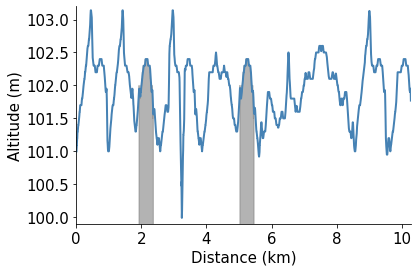

In [29]:
# Plotting
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df_stream["distance"], df_stream.altitude.rolling(window=10).mean().values, "steelblue", label="Altitude", lw=2)  # royalblue, steelblue
for s, e in start_end_indices:
    ax.fill_between(df_stream["distance"].tolist()[s:e], df_stream["altitude"].tolist()[s:e], color="dimgray", alpha=0.5)

ax.set(ylim=(df_stream["altitude"].min(), df_stream["altitude"].max()), xlim=(0, df_stream["distance"].max()), xlabel="Distance (km)", ylabel="Altitude (m)");

fdict["fname"] = f"{results_save_path}/altitude_run_id_{activity_id}.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# Map with segments

In [30]:
df_stream

,velocity_smooth,grade_smooth,cadence,distance,altitude,heartrate,time,lat,lng,time_min,pace_min,pace_sec
0,NaN,0.0,0,0.0000,101.0,107,0 days 00:00:00,50.142174,8.636042,0.000000,NaN,NaN
1,8.6400,0.0,0,0.0048,101.0,105,0 days 00:00:02,50.142154,8.635994,0.033333,6.944444,416.666667
2,6.5988,0.0,0,0.0055,101.0,107,0 days 00:00:03,50.142161,8.635985,0.050000,9.092562,545.553737
3,5.7600,0.0,0,0.0064,101.0,109,0 days 00:00:04,50.142171,8.635975,0.066667,10.416667,625.000000
4,6.0480,0.0,0,0.0084,101.0,110,0 days 00:00:05,50.142189,8.635967,0.083333,9.920635,595.238095
...,...,...,...,...,...,...,...,...,...,...,...,...
4854,5.0400,-3.1,75,10.2663,101.8,134,0 days 01:22:15,50.142316,8.635487,82.250000,11.904762,714.285714
4855,5.3280,-3.1,75,10.2685,101.7,134,0 days 01:22:16,50.142295,8.635496,82.266667,11.261261,675.675676
4856,4.9680,-2.6,62,10.2705,101.6,135,0 days 01:22:17,50.142276,8.635502,82.283333,12.077295,724.637681
4857,4.8240,-2.7,0,10.2724,101.6,135,0 days 01:22:18,50.142258,8.635508,82.300000,12.437811,746.268657


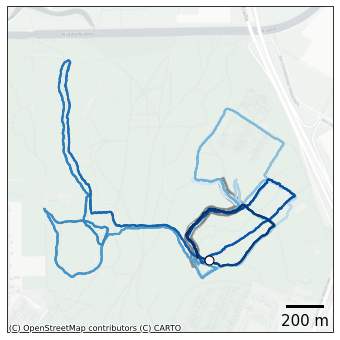

In [31]:
# Plot map
df_spatial = df_stream.copy()  # pd.DataFrame({"longitude": df_stream, "latitude": mean_ilat})
df_spatial["geometry"] = df_spatial.apply(lambda row: Point(row["lng"], row["lat"]), axis=1)
gdf = gpd.GeoDataFrame(df_spatial, geometry='geometry', crs="EPSG:4326")
dist_colors, dist_sm = create_scalarmappable("Blues", df_stream.distance.tolist(), vminmax=(0, df_stream.distance.max()))

fig, ax = plt.subplots(figsize=(6,6), subplot_kw={"projection": ccrs.epsg(3857)})
gdf = gdf.to_crs(epsg=3857)
xlimits, ylimits = pad_bounds(gdf.total_bounds, padding=200, square=True)

# Ax limits before basemap!
ax.set(xlim=xlimits, ylim=ylimits)
ctx.add_basemap(ax, source=xyz.CartoDB.Positron, crs=ccrs.epsg(3857))

# Plot data
ax.scatter(gdf.geometry.x[0], gdf.geometry.y[0], s=80, color=dist_colors[0], alpha=1, edgecolors="k", linewidths=1, zorder=5)
for s, e in start_end_indices:
     ax.plot(gdf.geometry.x[s:e], gdf.geometry.y[s:e], lw=8, color="dimgray", alpha=0.5)
plot_colorline(gdf.geometry.x, gdf.geometry.y, colors=dist_colors, ax=ax, lw=2, alpha=.9, zorder=4)

# Scalebar
scalebar = ScaleBar(1, units="m", location="lower right", scale_loc="bottom", length_fraction=0.25, box_alpha=.25)
ax.add_artist(scalebar);

fdict["fname"] = f"{results_save_path}/map_with_segments_run_id_{activity_id}.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

In [32]:
# Group by segment
grouped = df_seg_stream.groupby("effort")
print(grouped["segment_name"].unique().explode().value_counts())

grouped["seg_distance"].max().sort_values().index.values[:5]
print([f"{grouped.get_group(idx)['segment_name'].unique()}" for idx in grouped["seg_distance"].max().sort_values().index.values[:7]])

segment_name
Niddapark Trail    2
Name: count, dtype: int64
["['Niddapark Trail']", "['Niddapark Trail']"]


- segment grade profile

In [33]:
# yminmax = (grouped["grade_smooth"].min().min(), grouped["grade_smooth"].max().max())
# print(yminmax)  #yminmax = (-9,9)
# idx_sorted_seg_distance = grouped["seg_distance"].max().sort_values().index.values

# # Plotting
# fdict["fname"] = f"{results_save_path}/segments-in-run-grade-smooth-subplot-activity_id_{activity_id}.jpg"

# fig, ax = plt.subplots(len(idx_sorted_seg_distance), 1, figsize=(4,13))
# for nth, idx in enumerate(idx_sorted_seg_distance):
#     data = grouped.get_group(idx)
#     grade_smooth = data["grade_smooth"].rolling(window=10).mean().values
#     seg_distance = data["seg_distance"].values
#     ax[nth].fill_between(seg_distance, grade_smooth, label="effort", color="gray")
#     ax[nth].set(ylim=yminmax, yticks=[yminmax[0], 0, yminmax[1]])
#     if nth == len(idx_sorted_seg_distance)-1:
#         ax[nth].set(xlim=(0, grouped["seg_distance"].max().max()), xlabel="Distance (m)", ylabel="Grade (%)")
#     else:
#         ax[nth].set(xlim=(0, grouped["seg_distance"].max().max()), xticks=[], xticklabels=[], yticklabels=[])
#         ax[nth].spines["bottom"].set_visible(False)

# fig.savefig(**fdict) if SAVE_FIGURE else None

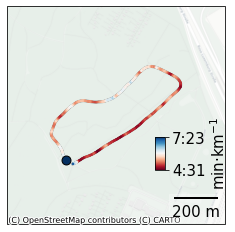

In [34]:
bar_loc = "lower right"
mean_colors, sm = create_scalarmappable("RdBu", list(mean_pace), vminmax=(min_pace, max_pace))

# Convert to GeoDataFrame
df_spatial = pd.DataFrame({"longitude": mean_ilong, "latitude": mean_ilat})
df_spatial["geometry"] = df_spatial.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
gdf = gpd.GeoDataFrame(df_spatial, geometry='geometry', crs="EPSG:4326")

# Cartopy projection
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"projection": ccrs.epsg(3857)})
gdf = gdf.to_crs(epsg=3857)
xlimits, ylimits = pad_bounds(gdf.total_bounds, padding=200, square=True)

# Ax limits before basemap!
ax.set(xlim=xlimits, ylim=ylimits)
ctx.add_basemap(ax, source=xyz.CartoDB.Positron, crs=ccrs.epsg(3857))

# Plot data
ax.scatter(gdf.geometry.x[0], gdf.geometry.y[0], s=80, color=mean_colors[0], alpha=1, edgecolors="k", linewidths=1, zorder=5)
ax.plot(gdf.geometry.x, gdf.geometry.y, "-", color="gray", lw=3, alpha=.75)
plot_colorline(gdf.geometry.x, gdf.geometry.y, colors=mean_colors, ax=ax, lw=2, alpha=.8)

# Colorbar
cax = inset_axes(ax, width="5%", height="20%", loc=bar_loc, bbox_to_anchor=(-0.175, 0.25, .9, .75) if bar_loc == "lower right" else (0.175, 0.25, .9, .75),  # adjust position inside ax (x0, y0, width, height)
                 bbox_transform=ax.transAxes, borderpad=0)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical', label='min·km$^{-1}$')
cbar.ax.set_yticks([max_pace, min_pace]);
cbar.ax.set_yticklabels([f"{format_pace(max_pace)}", f"{format_pace(min_pace)}"]);

# Scalebar
scalebar = ScaleBar(1, units="m", location=bar_loc, scale_loc="bottom", length_fraction=0.25, box_alpha=.25)
ax.add_artist(scalebar);

fdict["fname"] = f"{results_save_path}/map_and_mean-pace_single_segment_{name}.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# Map segment types

In [35]:
# Filter grade_dict and add color from segment_categories
filtered_grade_dict = {
    key: {**val, "color": next(data["color"] for _, data in segment_categories.items() if key in data["segments"])}
    for key, val in grade_dict.items()
    if any(key in data["segments"] for data in segment_categories.values())
}

# Compute total bounds (min/max latitude and longitude)
all_lats = np.concatenate([val["latitude"] for val in filtered_grade_dict.values()])
all_lons = np.concatenate([val["longitude"] for val in filtered_grade_dict.values()])
minx, maxx = all_lons.min(), all_lons.max()
miny, maxy = all_lats.min(), all_lats.max()

# Convert to EPSG:3857 for basemap compatibility
gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in zip(all_lons, all_lats)], crs="EPSG:4326").to_crs(epsg=3857)
xlimits, ylimits = pad_bounds(gdf.total_bounds, padding=500, square=True)

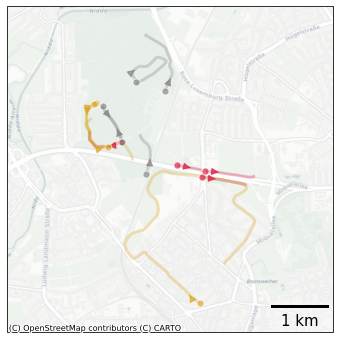

In [36]:
arrow_width = 1
arrow_start_idx = 150
arrow_end_idx = arrow_start_idx + arrow_width

# Set up figure and Cartopy projection
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": ccrs.epsg(3857)})

# Ax limits before basemap!
ax.set(xlim=xlimits, ylim=ylimits)
ctx.add_basemap(ax, source=xyz.CartoDB.Positron, crs=ccrs.epsg(3857))

# Plot filtered segments
for key, val in filtered_grade_dict.items():
    gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in zip(val["longitude"], val["latitude"])], crs="EPSG:4326").to_crs(epsg=3857)
    x, y = gdf.geometry.x.to_numpy(), gdf.geometry.y.to_numpy()

    ax.plot(x[25:], y[25:], color=val["color"], alpha=0.3, lw=3, zorder=2)
    ax.plot(x[0], y[0], "o", ms=7, color=val["color"], mec="w", alpha=0.65, zorder=3)
    ax.annotate("", xy=(x[arrow_end_idx], y[arrow_end_idx]), xytext=(x[arrow_start_idx], y[arrow_start_idx]),
                arrowprops=dict(arrowstyle="-|>", color=val["color"], lw=1, alpha=.7))

# Scalebar
scalebar = ScaleBar(1, units="m", location=bar_loc, scale_loc="bottom", length_fraction=0.25, box_alpha=.25)
ax.add_artist(scalebar);
#ax.set_aspect(1)

fdict["fname"] = f"{results_save_path}/map_segment_types_illustration.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# COMPOUND FIGURES

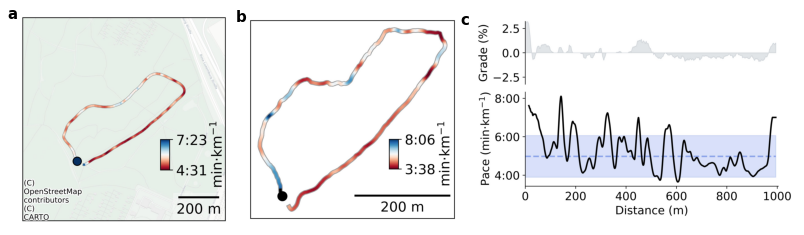

In [37]:
image_files = [
    f"{results_save_path}/map_and_mean-pace_single_segment_{name}.jpg",
    f"{results_save_path}/best_pace_color-coded_segment_{name}_topn_{1}_geopandas.jpg",
    f"{results_save_path}/best_pace_interpolated_grade_segment_{name}_topn_{1}.jpg",
]

panel_labels = ["a", "b", "c"]
fig_width = 14 # 8.27  # Standardbreite (A4 = 8.27 Zoll)
wspace = .05

fig, axes = plt.subplots(1, 3, figsize=(fig_width, 4), gridspec_kw={"hspace": 0.05, "wspace": wspace, "width_ratios" : [1, 1, 1.5]})
axes = axes.flatten()

for ax, file, label in zip(axes, image_files, panel_labels):
    img = mpimg.imread(file)
    ax.imshow(img)
    ax.axis('off')
    ax.text(-0.04, 1.02, label, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')

fdict["fname"] = f"{compound_figure_path}/compound-segments-figure-2-a-to-c.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

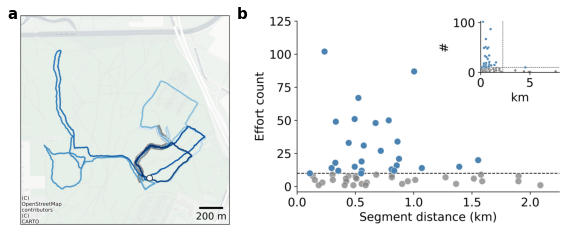

In [38]:
image_files = [
    f"{results_save_path}/map_with_segments_run_id_{activity_id}.jpg",
    f"{results_save_path}/segment_effort_counts_minnumefforts_{min_num_efforts}_thresholding.jpg"
]

panel_labels = ["a", "b"]
fig_width = 10 # 8.27  # Standardbreite (A4 = 8.27 Zoll)
wspace = .025

fig, axes = plt.subplots(1, 2, figsize=(fig_width, 4), gridspec_kw={"hspace": 0.05, "wspace": wspace, "width_ratios" : [1, 1.5]})
axes = axes.flatten()

for ax, file, label in zip(axes, image_files, panel_labels):
    img = mpimg.imread(file)
    ax.imshow(img)
    ax.axis('off')
    ax.text(-0.04, 1.02, label, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')

fdict["fname"] = f"{compound_figure_path}/compound-segments-figure-0-a-to-b.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

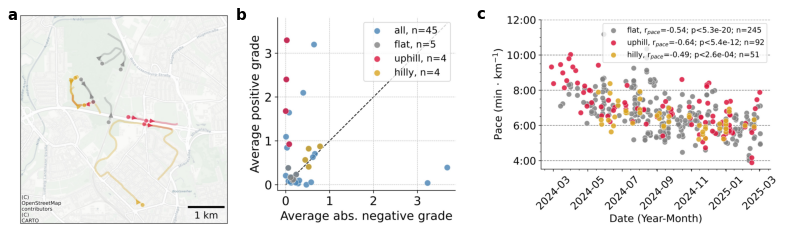

In [39]:
image_files = [
    f"{results_save_path}/map_segment_types_illustration.jpg",
    f"{results_save_path}/segments_summed_grade_nsegments{len(grade_dict.keys())}.jpg",
    f"{results_save_path}/pooled_pace_vs_effort_segment_for_flat_hilly_uphill.jpg"
]

panel_labels = ["a", "b", "c"]
fig_width = 14 # 8.27  # Standardbreite (A4 = 8.27 Zoll)
wspace = .05

fig, axes = plt.subplots(1, 3, figsize=(fig_width, 4), gridspec_kw={"hspace": 0.05, "wspace": wspace, "width_ratios" : [1, 1, 1.5]})
axes = axes.flatten()

for ax, file, label in zip(axes, image_files, panel_labels):
    img = mpimg.imread(file)
    ax.imshow(img)
    ax.axis('off')
    ax.text(-0.04, 1.02, label, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')

fdict["fname"] = f"{compound_figure_path}/compound-segments-figure-1-a-to-c.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# cross-correlation

In [40]:
# dist_bin_size = np.round(plot_df["distance"].diff().values[-1] * 1000, 1)
# x, y = mean_pace, mean_grade

# cross_corr = np.correlate(x, y, mode="full")
# lags = np.arange(-len(x) + 1, len(x)) * dist_bin_size

# x_norm = (x - np.mean(x)) #/ np.std(x)
# y_norm = (y - np.mean(y)) #/ np.std(y)

# cross_corr = np.correlate(x_norm, y_norm, mode="full")
# cross_corr = cross_corr / np.max((np.max(cross_corr), np.abs(np.min(cross_corr))))

# fig, ax = plt.subplots()
# #ax.hlines()
# ax.plot(lags, cross_corr, lw=2, color="royalblue")
# ax.set(ylim=(-1.1, 1.1), xlim=(-750,750), xlabel="Lag (meters)", ylabel="Cross-correlation");